# Monkey Functions
- 1.) Make pipeline for predictions
- 2.) Cycle through all the features and make predictions 
- 3.) Make software that allows for the user to enter the following and get preditctions out of it (i.e. train on all data and get novel predictions - dramatic presentation)
    - Age
    - Sex
    - Dose
    - Time since Irradiation
- 4.) Incorporate optimization in the pipeline
- 5.) Pipeline for health outcomes
    - able to cycle through as well

In [7]:
### Using monkey_env/ ###
### If giving a tqb error, run this code twice###

# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
#import statsmodels.imputation.mice as smi
#import scipy.cluster.hierarchy as hac
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost
from catboost import Pool

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

import catboost as cb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#fix the error that pops up about ipwydgets 
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm

import warnings
warnings.filterwarnings("ignore")

print("Setup Complete")


/Users/aidanlew/Desktop/cmb/codes/monkey_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup Complete


In [8]:
pwd

'/Users/aidanlew/Desktop/cmb/codes/monkey_irrad_sept-2022'

In [9]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [10]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%y')


# Predicting Biomarker Levels and Health Outcomes

## Data loading

In [11]:
# Make a df of the binary health data of the monkeys
minhealth_monkey_df = pd.read_excel('../Documents/demographic_data_r2.xlsx',
                    sheet_name=2,
                    skiprows = 0,
                    #usecols = ,
                    engine = 'openpyxl',
                    date_parser=parser
                         )

minhealth_monkey_df['Animal_Status'] = minhealth_monkey_df['Animal_Status'].map({'LIVING':1, 'DECEASED': 0})
#minhealth_monkey_df.head(15)
minhealth_monkey_df.columns


Index(['ID', 'Time_Under_Observation_(yrs)', 'Dose_(Gy)', 'Irrad_Age_(months)',
       'Years_Since_Irrad', 'Current_Age_(years)', 'Animal_Status',
       'Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)'],
      dtype='object')

In [12]:
# See our monkey sample size
print('Total Monkeys:{}'.format(minhealth_monkey_df['ID'].nunique()))
 
# Count the control monkeys
print('Non-Irradiated Monkeys:{}'.format(minhealth_monkey_df['Dose_(Gy)'].value_counts()[0]))
 
# Count the irradiated monkeys
#print('Irradiated Samples:{}'.format(minhealth_monkey_df['Dose_(Gy)'].value_counts()[!=0]))



Total Monkeys:152
Non-Irradiated Monkeys:32


In [13]:
#Makee a df for the blood analytic data
minbio_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
minbio_monkey_df.set_index(['ID'])
minbio_monkey_df['ID'] = minbio_monkey_df['ID'].astype(str)

#minbio_monkey_df.dropna(axis=0, inplace=True) 

minbio_monkey_df.columns
#minbio_monkey_df.tail()


Index(['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

In [14]:
#Makee a df were there is one monkey's data missing (the same in the single_monkey_df)
oneless_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
oneless_df.set_index(['ID'])

oneless_df['ID'] = oneless_df['ID'].astype(str)

#oneless_dff.dropna(axis=0, inplace=True) 

#oneless_df.columns
oneless_df.tail()

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4529,2112,Rhesus-Chinese,2020-09-23 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,67.0,6.2,1.1,0.0,1696,4422,409,73,0,289
4530,2112,Rhesus-Chinese,2021-03-04 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,56.1,9.1,1.5,0.0,1312,2210,359,59,0,284
4531,2210,Rhesus-Indian,2021-09-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,26.8,12.3,1.2,0.0,3104,1394,640,62,0,311
4532,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4533,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [15]:
# Make a df of a single monkey's blood analytic data
single_minbio_df = minbio_monkey_df.copy()
single_minbio_df = single_minbio_df[single_minbio_df['ID'] == '2046']
single_minbio_df.set_index(['ID'])
#single_minbio_df.reset_index()
single_minbio_df.head()


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,2017-11-02,Yes,2014-04-09,2007-07-03,F,Clinical,1303.0,43.0,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,2017-12-13,Yes,2014-04-09,2007-07-03,F,Clinical,1344.0,44.0,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386
35,2046,Rhesus-Chinese,2018-01-02,Yes,2014-04-09,2007-07-03,F,Research,1364.0,45.0,...,39.9,6.0,0.3,0.3,2140,1596,240,12,12,309
36,2046,Rhesus-Chinese,2018-01-31,Yes,2014-04-09,2007-07-03,F,Research,1393.0,46.0,...,46.8,5.6,0.5,0.0,2025,2012,241,22,0,275
37,2046,Rhesus-Chinese,2018-04-05,Yes,2014-04-09,2007-07-03,F,Research,1457.0,48.0,...,22.8,5.8,0.1,0.1,6123,1961,499,9,9,325


# PLOTTING FUNCTION 

In [42]:
def predict_and_plot(model, X_validation, y_validation, y):
    
    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )

    
    #Save the plot
    fig_name = input('Figure name')
    plt.savefig("%s.png" % fig_name, dpi=900, bbox_inches='tight')
    
    ### Feature Importance ###

    feat = model.get_feature_importance(data=pool,
                       prettified=True,

    )
    
    print(feat)
    
    #print('MSE: {}'.format(mean_squared_error(y_validation, a_df)))

# MODEL FUCTION

In [17]:
def regression_model_formation (X,y,cat_features):
    model = input('Model Name')
    iterations = float(input('Iterations'))
    learning_rate = float(input('Learning Rate'))
    early_stopping_rounds = float(input('Stopping Rounds'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,cat_features=cat_features  
         )

# MODEL, PREDICT, AND PLOT FXN

In [41]:
def model_pred_plot (X, y, cat_features, X_validation, y_validation):
    ### Model Formation ###
    model = input('Model Name')
    iterations = float(input('Iterations'))
    learning_rate = float(input('Learning Rate'))
    early_stopping_rounds = float(input('Stopping Rounds'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,cat_features=cat_features  
         )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)


    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    ### Plotting ###
    
    #Plot axis titles
    xlab = input("X axis name:")
    ylab = input("Y axis name:")
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,
                 fontsize=15
    )
    
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
   
    #Save the plot
    fig_name = input('Figure name')
    plt.savefig("%s.png" % fig_name, dpi=900, bbox_inches='tight')
    
    

# DATA SETUP FUNCTION

In [19]:
def data_setup (df):
  ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    global X, y, ylabel
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    global cat_features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    global pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    global  X_train, X_validation, y_train, y_validation
    X_train, X_validation, y_train, y_validation= data
    
    global train_pool
    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )
    
    global validation_pool
    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )


# PIPELINE FOR REGRESSION


In [44]:
def regression_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )
    

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )
    
    ### Model Formation ###
    iterations = float(input('Iterations:'))
    learning_rate = float(input('Learning Rate:'))
    early_stopping_rounds = float(input('Stopping Rounds:'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X_train, y_train,
              cat_features=cat_features,
              verbose=False
         )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)

   
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    
    #Save the plot
    fig_name = input('Figure name')
    plt.savefig("catboost_%s.png" % fig_name, dpi=900, bbox_inches='tight')

    ### Feature Importance ###

    feat = model.get_feature_importance(data=pool,
                       prettified=True,

    )
    
    print(feat)
    

# HEALTH OUTCOME PIPELINE

In [45]:
def classifier_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )
    
    ### Model Formation ###
    iterations = float(input('Iterations:'))
    learning_rate = float(input('Learning Rate:'))
    early_stopping_rounds = float(input('Stopping Rounds:'))
    
    model = CatBoostClassifier(iterations=iterations, 
                              learning_rate=learning_rate,
                               loss_function='Logloss',
                               custom_loss=['AUC','Accuracy'],
                               early_stopping_rounds= early_stopping_rounds
    )
   

    model.fit(X_train, y_train, 
              cat_features=cat_features, 
              verbose=False  
    )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)

    ### Plotting ###
    # make confusion matrix
    cm = confusion_matrix(y_validation, a_df)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  #display_labels=clf.classes_
                                 )
    
    disp.plot()
    plt.grid(False)


    Accuracy = metrics.accuracy_score(y_validation, a_df)
    Precision = metrics.precision_score(y_validation, a_df)

    
    #Save the plot
    fig_name = input('Figure name')
    plt.savefig("catboost_%s.png" % fig_name, dpi=900, bbox_inches='tight')

    
    print('Accuracy:',Accuracy, 'Precision:',Precision)
    print(classification_report(y_validation, a_df))

# OPTOMIZED REGRESSION

In [46]:
def objective(trial):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        #"iterations" : trial.suggest_int("iterations", 1, 100000),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = cb.CatBoostRegressor(**param)

    model.fit(X_train, y_train, cat_features=cat_features, eval_set=[(X_validation, y_validation)], verbose=0, early_stopping_rounds=100)

    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    accuracy = r2_score(y_validation, a)
    return accuracy


In [47]:
def opomized_regression_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    data_setup(df)
    
    opq = int(input('Do you want this potomized? (1/0)'))
    
    if opq == 1:
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=50, timeout=600)
        trial = study.best_trial
        
        model = CatBoostRegressor(**trial.params)
        model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
        
        predict_and_plot(model, X_validation, y_validation, y)
        
    else: 
        ### Model Formation ###
        iterations = float(input('Iterations:'))
        learning_rate = float(input('Learning Rate:'))
        early_stopping_rounds = float(input('Stopping Rounds:'))

        model = CatBoostRegressor(iterations=iterations, 
                                  learning_rate=learning_rate,
                                   early_stopping_rounds= early_stopping_rounds
                                 )
        model.fit(X_train, y_train,
                  cat_features=cat_features,
                  verbose=False
             )

        predict_and_plot(model, X_validation, y_validation, y)

# Single Monkey Preditions, whole data

In [24]:
#make a parent df
single_minbio_df.copy()
sreg_df = single_minbio_df

#Exclude datetime feautres
sreg_df=sreg_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
sreg_df.head(2)


,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,Yes,F,Clinical,1303.0,43.0,81.0,1.14,10.3,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,Yes,F,Clinical,1344.0,44.0,81.0,1.14,10.4,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386


regression_pipeline (sreg_df)

In [ ]:
# Optuna doesn't work with such small sampling
opomized_regression_pipeline (sreg_df)

# Multi Monkey Predictions, whole data

In [39]:
#make a parent df
minbio_monkey_df.copy()
mreg_df = minbio_monkey_df

#Exclude datetime feautres
mreg_df=mreg_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
mreg_df.head(5)


,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,No,F,Clinical,NaN,NaN,NaN,NaN,10.6,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.7,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334
2,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.9,...,8.5,3.4,0.1,0.1,15383,1488,595,18,18,321
3,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,11.3,...,5.5,2.7,0.1,0.0,19349,1161,570,21,0,310
4,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,11.6,...,14.5,6.6,0.1,0.0,9062,1668,759,12,0,486


Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 4


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 10
Learning Rate: 0.5
Stopping Rounds: 5
Plot Title: t


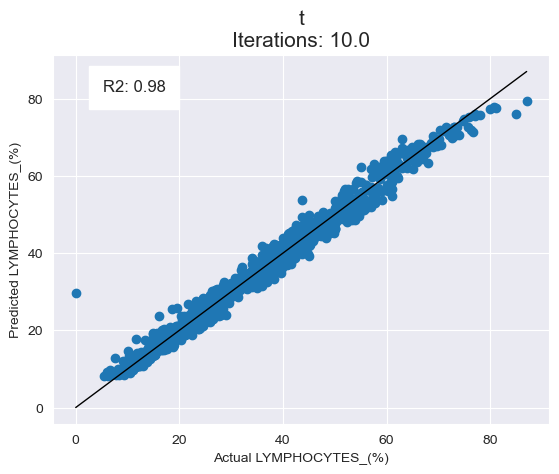

                                           Feature Id  Importances
0                                            NEUT_(%)    86.651296
1                                     ABS_LYMPH_(/uL)     5.056368
2                                      ABS_MONO_(/uL)     2.967779
3                                       ABS_EOS_(/uL)     1.682345
4                                            MONO_(%)     1.554043
5                                             EOS_(%)     0.890583
6                                                 SEX     0.414483
7                                                 AGE     0.265342
8                                PLATLET_COUNT_(K/uL)     0.185069
9                                    Hemocrit_(HCT_%)     0.169562
10                                           BASO_(%)     0.045291
11                                    MONTHS AT IRRAD     0.036440
12                                          DOSE_(Gy)     0.025406
13                                     ABS_NEUT_(/uL)     0.02

In [95]:
regression_pipeline(mreg_df)

Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 4
Test Size 0.3
Do you want this potomized? (1/0) 1
Plot Title: optomized


                                           Feature Id  Importances
0                                            NEUT_(%)    48.983695
1                                     ABS_LYMPH_(/uL)    19.646744
2                                      ABS_NEUT_(/uL)    18.187191
3                                          WBC_(K/uL)     2.941341
4                                             EOS_(%)     1.456191
5                                       ABS_EOS_(/uL)     1.365070
6                                      ABS_MONO_(/uL)     1.011283
7                                    DAYS_SINCE_IRRAD     0.843320
8                                            MONO_(%)     0.693983
9                                                 AGE     0.589995
10                                   Hemocrit_(HCT_%)     0.587295
11                                           BASO_(%)     0.495831
12                                 MONTHS_SINCE_IRRAD     0.482448
13                               PLATLET_COUNT_(K/uL)     0.48

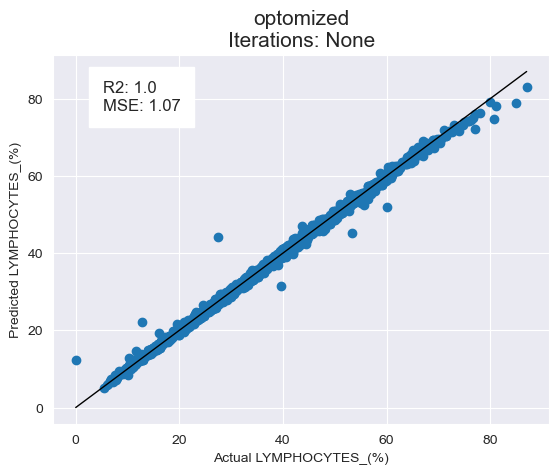

In [40]:
opomized_regression_pipeline (mreg_df)

## Prediction of biomarkers

### A. Predictions using only the top 5 important features
top 5 features found in section 1.a. Using the top 5 features found from each model (single v. multi monkey)

#### Single Monkey:
Top 5 features: 
- 0 NEUT_(%)	26.502043
- 1	TYPE	12.952220
- 2	ABS_LYMPH_(/uL)	12.820068
- 3	EOS_(%)	11.754037
- 4	RBC_(M/uL)	11.554449


In [ ]:
### Make the reduced df

#make a parent df
single_minbio_df.copy()
sred_reg_df = single_minbio_df[['ID', 'TYPE', 'NEUT_(%)', 'ABS_LYMPH_(/uL)',
                                'EOS_(%)','RBC_(M/uL)', 'LYMPHOCYTES_(%)']]
regression_pipeline(sred_reg_df)

#### Multi Monkey
Top 5 features:
- 0 NEUT_(%)	92.324836
- 1	ABS_LYMPH_(/uL)	3.185803
- 2	ABS_MONO_(/uL)	2.682848
-  3	EOS_(%)	1.198216
- 4	Hemaglobin_(HGB_g/dL)	0.559005

Also try with just NEUT_(%) since it is so heavily weighted

In [64]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mred_reg_df = minbio_monkey_df[['ID', 'ABS_MONO_(/uL)', 'NEUT_(%)', 'ABS_LYMPH_(/uL)',
                                'EOS_(%)','Hemaglobin_(HGB_g/dL)', 'LYMPHOCYTES_(%)']]


#regression_pipeline(mred_reg_df)


### B. Predicting lymphocytes with only the irradiation data


#### Multi Monkey only
No variation for single monkey model formation

In [66]:
mred_reg_df

,ID,ABS_MONO_(/uL),NEUT_(%),ABS_LYMPH_(/uL),EOS_(%),Hemaglobin_(HGB_g/dL),LYMPHOCYTES_(%)
0,2061,818,43.5,5232,0.9,12.0,48.0
1,2061,396,74.0,1883,0.1,10.5,21.4
2,2061,595,87.9,1488,0.1,10.5,8.5
3,2061,570,91.7,1161,0.1,10.4,5.5
4,2061,759,78.8,1668,0.1,8.4,14.5
...,...,...,...,...,...,...,...
4547,2112,409,25.7,4422,1.1,11.7,67.0
4548,2112,359,33.3,2210,1.5,12.4,56.1
4549,2210,640,59.7,1394,1.2,13.0,26.8
4550,2210,632,51.2,2100,1.7,13.2,36.2


In [67]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mrad_reg_df = minbio_monkey_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]


#regression_pipeline(mrad_reg_df)


#### single monkey only

In [68]:
### Make the reduced df

#make a parent df
single_minbio_df.copy()
srad_reg_df = single_minbio_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]
srad_reg_df.tail(2)

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,LYMPHOCYTES_(%)
49,2046,Yes,F,2570.0,84.0,81.0,1.14,13.8,58.3
50,2046,Yes,F,2738.0,90.0,81.0,1.14,14.3,52.8


## Predictions of the health outcomes
Doesn't make sense to predict or use single monkey moels/data becuase there is only one observation per monkey

In [97]:
minhealth_monkey_df.head(2)

,ID,Time_Under_Observation_(yrs),Dose_(Gy),Irrad_Age_(months),Years_Since_Irrad,Current_Age_(years),Animal_Status,Diabetes_(Y/N),Cataracts_(Y/N),Arthritis_(Y/N),...,Hypertension_(Y/N),Testicular Atrophy_(Y/N),Ovarian Dysfunction_(Y/N),Hepatic_(Y/N),Kidney_(Y/N),Lung_(Y/N),Bone_(Y/N),Overweight_(Y/N),Underweight_(Y/N),Brain Lesion_(Y/N)
0,1423,1.380822,0.0,NaN,NaN,9.947945,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1484,11.868493,0.0,NaN,NaN,19.276712,1,0,1,1,...,0,0,0,0,0,1,0,1,0,0


### A. Multi Monkey using only top 5 features
- 0. Dose_(Gy)	14.984810
- 1	Heart_(Y/N)	14.908153
- 2	Time_Under_Observation_(yrs)	13.851867
- 3	Overweight_(Y/N)	11.484527
- 4	Years_Since_Irrad	11.038610

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 100000
Learning Rate: 0.5
Stopping Rounds: 100000


Accuracy: 0.782608695652174 Precision: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        37
           1       0.33      0.11      0.17         9

    accuracy                           0.78        46
   macro avg       0.57      0.53      0.52        46
weighted avg       0.72      0.78      0.74        46



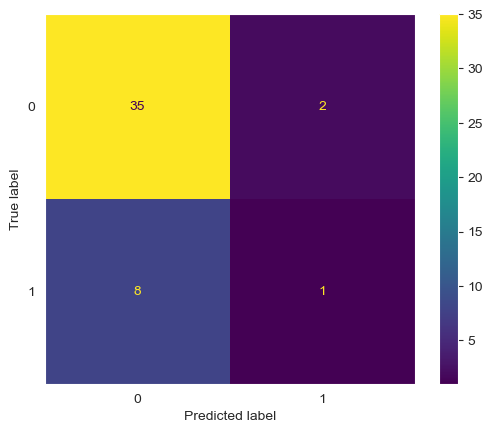

In [115]:
### Make the reduced df

#make a parent df
minhealth_monkey_df.copy()
five_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Heart_(Y/N)', 'Time_Under_Observation_(yrs)',
                                'Overweight_(Y/N)','Years_Since_Irrad', 'Tumor_(Y/N)']]

classifier_pipeline (five_health_df)

### B. Multi monkey with only the radiation data

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 100
Learning Rate: 0.5
Stopping Rounds: 5


Accuracy: 0.6956521739130435 Precision: 0.0
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        37
           1       0.00      0.00      0.00         9

    accuracy                           0.70        46
   macro avg       0.39      0.43      0.41        46
weighted avg       0.63      0.70      0.66        46



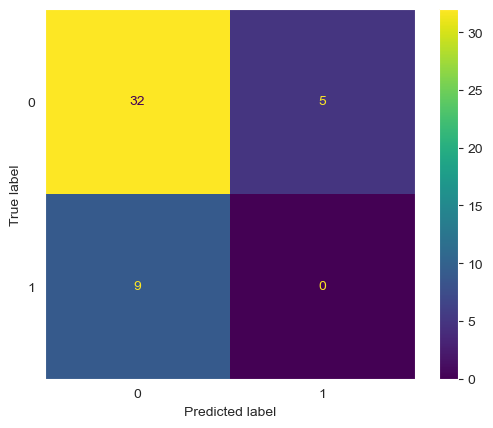

In [101]:
### Make the reduced df

#make a parent df
minhealth_monkey_df.copy()
rad_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Irrad_Age_(months)',
                                           'Years_Since_Irrad', 'Current_Age_(years)', 'Tumor_(Y/N)']]

classifier_pipeline (rad_health_df)

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 1000
Learning Rate: 0.5
Stopping Rounds: 1000


Accuracy: 0.8043478260869565 Precision: 0.5
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        37
           1       0.50      0.33      0.40         9

    accuracy                           0.80        46
   macro avg       0.68      0.63      0.64        46
weighted avg       0.78      0.80      0.79        46



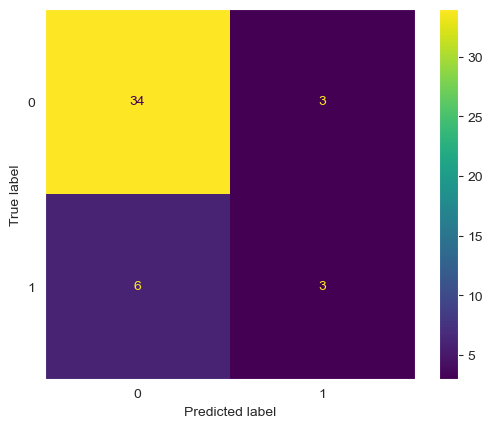

In [106]:
minhealth_monkey_df.head()

classifier_pipeline (minhealth_monkey_df)

## Predicting dose 

In [26]:
#make single monkey
single_minbio_df.copy()
single_dose_df = single_minbio_df

#fill na values to 0
single_dose_df[['DOSE_(Gy)']]= single_dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)



#make multi monkey df
minbio_monkey_df.copy()
dose_df = minbio_monkey_df

#fill na values to 0
dose_df[['DOSE_(Gy)']]= dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)

dose_df['DOSE_(Gy)']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4547    0.0
4548    0.0
4549    0.0
4550    0.0
4551    0.0
Name: DOSE_(Gy), Length: 4552, dtype: float64

In [27]:
dose_df = dose_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)

Target Feature Column: DOSE_(Gy)
How many catagorical columns: 4
Test Size 0.3
Iterations: 1000
Learning Rate: 0.5
Stopping Rounds: 5
Plot Title: Dose Predictions


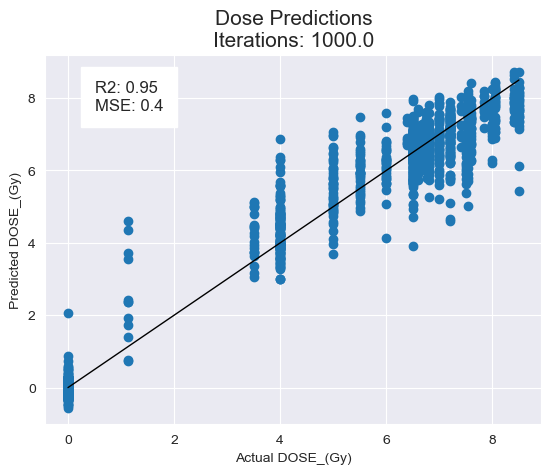

MSE: 0.40280746483769386
                                           Feature Id  Importances
0                                  MONTHS_SINCE_IRRAD    52.838634
1                                     MONTHS AT IRRAD    25.466664
2                                    DAYS_SINCE_IRRAD     5.794861
3                                                 SEX     2.094320
4                Mean_corpuscular_hemaglobin_(MCH_pg)     1.550753
5                                                 AGE     1.516966
6                                          RBC_(M/uL)     1.430748
7                    Mean_corpuscular_volume_(MCV_fL)     1.420440
8                                PLATLET_COUNT_(K/uL)     0.984636
9                                             Species     0.953250
10                                         WBC_(K/uL)     0.778311
11                                      ABS_EOS_(/uL)     0.727336
12  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.615141
13                                   

In [30]:
regression_pipeline(dose_df)

# Cycle through the different features

# REGRESSION CYCLER

In [54]:
def cycle_feature_regression_predictions (df):
    
    cat_list = ['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']
    cat_cols = int(input('How many catagorical columns:'))
    
    for (columnName, columnData) in df.iteritems():
        if columnName in  cat_list:
            continue
        else:     
            ### Data Setup ###

            (train_df, test_df)= df, df 

            #data labeling
            ylabel = columnName
            y = df[ylabel]
            X = df.drop(['ID',ylabel],axis=1)

            #declare catagorical features
            cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))

            #put data into pool
            pool = Pool(data=X, label=y, cat_features=cat_features)

            #train tesr split
            #test_size = float(input('Test Size'))
            test_size = 0.3
            data= train_test_split(X, y, test_size=test_size, random_state=0)

            #The order of this matters#
            X_train, X_validation, y_train, y_validation= data

            train_pool = Pool(
                data = X_train,
                label = y_train,
                cat_features = cat_features
            )


            validation_pool = Pool(
                data = X_validation,
                label = y_validation,
                cat_features = cat_features
            )

            ### Model Formation ###
            #iterations = float(input('Iterations:'))
            #learning_rate = float(input('Learning Rate:'))
            #early_stopping_rounds = float(input('Stopping Rounds:'))
            iterations = 1000
            learning_rate = 0.5
            early_stopping_rounds = 2


            model = CatBoostRegressor(iterations=iterations, 
                                      learning_rate=learning_rate,
                                       early_stopping_rounds= early_stopping_rounds
                                     )
            model.fit(X_train,y_train,
                      cat_features=cat_features,
                      verbose=False
                 )

            ### Predictions ###
            a = model.predict(X_validation)
            a_df = pd.DataFrame(a)


            ### Plotting ###
            # Plot the predictions
            fig, ax = plt.subplots()
            ax.scatter(y_validation, a_df)

            ax.plot([y.min(), y.max()], [y.min(), y.max()], 
                    'k-', 
                    linewidth=1, 
                    markersize=120
            )

            #Plot axis titles
            ax.set_xlabel('Actual {}'.format(str(ylabel)))
            ax.set_ylabel('Predicted {}'.format(str(ylabel)))

            #Title of the plot
            #plot_title = input("Plot Title:")
            #show_iters = model.get_param('iterations')  
            ax.set_title("CatBoost %s Predictions" % ylabel
                         ,fontsize=15
            )

            #cordinates for the R2 value box
            xmin, xmax, ymin, ymax = plt.axis()
            yrange = ymax-ymin
            xrange = xmax-xmin


            #Plotting the R2 score and MSE
            ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
            )
    

            plt.show() 
            
            #Save the plot
            fig_name = ylabel
            plt.savefig("catboost_cycle_%s.png" % fig_name, dpi=900, bbox_inches='tight')

        
            ### Feature Importance ###

            feat = model.get_feature_importance(data=pool,
                               prettified=True,

            )

            print(feat)


In [32]:
def facet (df):

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle("Biomarker Predictions", fontsize=18, y=0.95)

    # set number of columns (use 3 to demonstrate the change)
    ncols = 6

    # calculate number of rows
    #nrows = len(tickers) // ncols + (len(tickers) % ncols > 0)
    nrows = 5
    n = 0 
   



    cat_list = ['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']
    cat_cols = 4#int(input('How many catagorical columns:'))
    
    for (columnName, columnData) in df.iteritems():
        if columnName in  cat_list:
            continue
        else:        
            n=n+1
            # add a new subplot iteratively using nrows and cols
            
            
            ax = plt.subplot(nrows, ncols, n+1 )
            ax.scatter(df[columnName],df[columnName])

    

            # filter df and plot ticker on the new subplot axis
            df[columnName].plot(ax=ax)

            # chart formatting
            ax.set_title(columnName.upper())
            #ax.get_legend().remove()
            ax.set_xlabel("")

In [ ]:
facet (cyclebio_df)

In [33]:
### make a parent df
minbio_monkey_df.copy()
cyclebio_df = minbio_monkey_df

#Exclude datetime feautres
cyclebio_df=cyclebio_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
cyclebio_df['DOSE_(Gy)'] = cyclebio_df['DOSE_(Gy)'].fillna(0)
cyclebio_df.head(2)

,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,No,F,Clinical,NaN,NaN,NaN,0.0,10.6,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,0.0,10.7,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


How many catagorical columns: 4


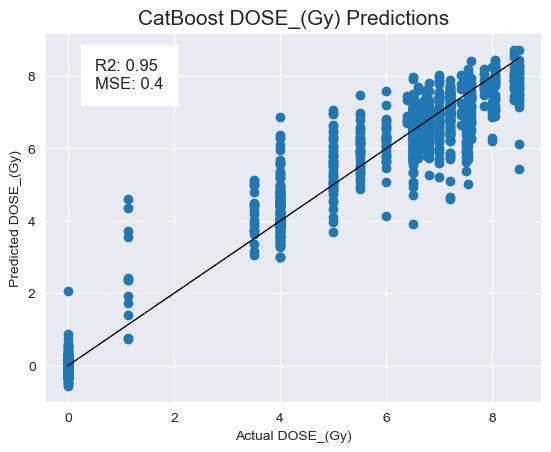

                                           Feature Id  Importances
0                                  MONTHS_SINCE_IRRAD    52.838634
1                                     MONTHS AT IRRAD    25.466664
2                                    DAYS_SINCE_IRRAD     5.794861
3                                                 SEX     2.094320
4                Mean_corpuscular_hemaglobin_(MCH_pg)     1.550753
5                                                 AGE     1.516966
6                                          RBC_(M/uL)     1.430748
7                    Mean_corpuscular_volume_(MCV_fL)     1.420440
8                                PLATLET_COUNT_(K/uL)     0.984636
9                                             Species     0.953250
10                                         WBC_(K/uL)     0.778311
11                                      ABS_EOS_(/uL)     0.727336
12  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.615141
13                                    ABS_LYMPH_(/uL)     0.53

<Figure size 640x480 with 0 Axes>

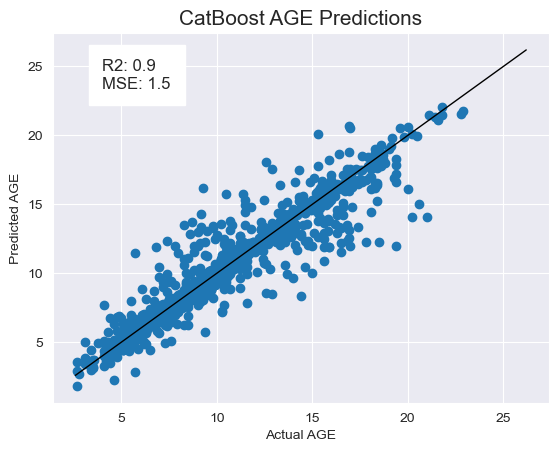

                                           Feature Id  Importances
0                                     MONTHS AT IRRAD    30.976083
1                                    DAYS_SINCE_IRRAD    13.112349
2                                           DOSE_(Gy)    12.407258
3                                  MONTHS_SINCE_IRRAD    12.031168
4                                             Species    10.967439
5                                            MONO_(%)     2.408904
6                                PLATLET_COUNT_(K/uL)     2.148329
7                                                 SEX     2.101515
8                                    Hemocrit_(HCT_%)     1.917453
9                                     ABS_LYMPH_(/uL)     1.582021
10  Mean_corpuscular_hemaglobin_concentration_(MCH...     1.224726
11                              Hemaglobin_(HGB_g/dL)     1.050046
12               Mean_corpuscular_hemaglobin_(MCH_pg)     1.015374
13                                     ABS_MONO_(/uL)     0.91

<Figure size 640x480 with 0 Axes>

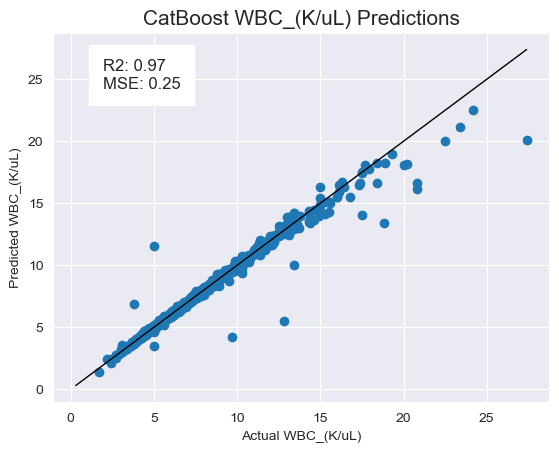

FileNotFoundError: [Errno 2] No such file or directory: 'catboost_cycle_WBC_(K/uL).png'

<Figure size 640x480 with 0 Axes>

In [55]:
cycle_feature_regression_predictions(cyclebio_df)

#4,3,3,3,3,4---

# OPTOMIZED REGRESSION CYCLER

In [36]:
def cycler_data_setup (df):

    ### Data Setup ###

    (train_df, test_df)= df, df 

    #data labeling
    
    global ylabel, y, X
    ylabel = columnName
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)

    #declare catagorical features
    global cat_features
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))

    #put data into pool
    global pool
    pool = Pool(data=X, label=y, cat_features=cat_features)

    #train tesr split
    #test_size = float(input('Test Size'))
    test_size = 0.3
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    global  X_train, X_validation, y_train, y_validation
    X_train, X_validation, y_train, y_validation= data

    global train_pool
    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )

    global validation_pool
    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )


In [37]:
def cycler_plotter (model, X_validation, y_validation, y):
        ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )

    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    #plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(ylabel + "\nIterations: {}".format(str(show_iters))
                 ,fontsize=15
    )

    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin


    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    

    plt.show() 

    ### Feature Importance ###

    feat = model.get_feature_importance(data=pool,
                       prettified=True,

    )

    print(feat)
    

In [38]:
def cycler_objective(trial):
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        #"iterations" : trial.suggest_int("iterations", 1, 100000), - makes too long/comp really doesn't like it
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = cb.CatBoostRegressor(**param)

    model.fit(X_train, y_train, cat_features=cat_features, eval_set=[(X_validation, y_validation)], verbose=0, early_stopping_rounds=100)

    global a, a_df
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    accuracy = r2_score(y_validation, a)
    return accuracy


In [39]:
def optomized_regression_cycler (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
        
    global cat_cols
    cat_cols = int(input('How many catagorical columns:'))
    cat_list = ['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']   
    
    global columnName, columnData
    for (columnName, columnData) in df.iteritems():
        if columnName in  cat_list:
            continue
        else:     
            cycler_data_setup (df)
            
            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(direction="maximize")
            study.optimize(cycler_objective, n_trials=50, timeout=600)
            trial = study.best_trial
            optuna.logging.set_verbosity(optuna.logging.WARNING)
            
            model = CatBoostRegressor(**trial.params, iterations=1000,early_stopping_rounds=5)
            model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
            
            cycler_plotter (model, X_validation, y_validation, y)


How many catagorical columns: 4


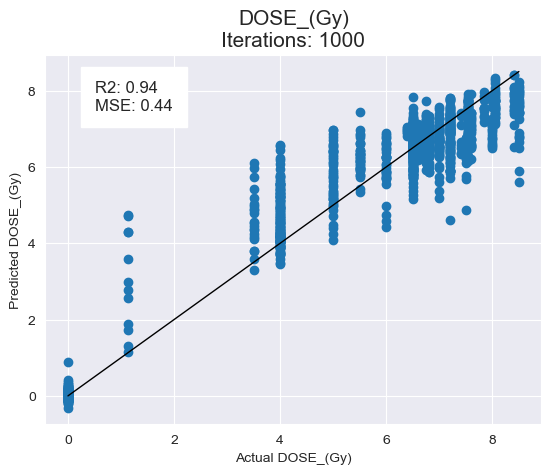

                                           Feature Id  Importances
0                                     MONTHS AT IRRAD    42.056471
1                                  MONTHS_SINCE_IRRAD    19.407454
2                                               IRRAD     8.907920
3                                    DAYS_SINCE_IRRAD     3.810313
4                                                 SEX     3.360301
5                                                 AGE     2.665404
6                                             Species     2.382080
7                Mean_corpuscular_hemaglobin_(MCH_pg)     2.320969
8                                          RBC_(M/uL)     1.655120
9                                    Hemocrit_(HCT_%)     1.581269
10                   Mean_corpuscular_volume_(MCV_fL)     1.489797
11                               PLATLET_COUNT_(K/uL)     1.387175
12                                         WBC_(K/uL)     1.259410
13                              Hemaglobin_(HGB_g/dL)     1.05

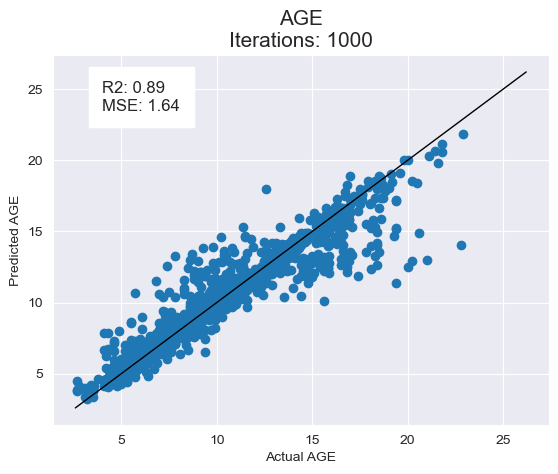

                                           Feature Id  Importances
0                                    DAYS_SINCE_IRRAD    15.627789
1                                  MONTHS_SINCE_IRRAD    15.412656
2                                     MONTHS AT IRRAD    14.762717
3                                               IRRAD    10.421241
4                                           DOSE_(Gy)     7.297110
5                                             Species     7.222939
6                                            MONO_(%)     3.065735
7                                          RBC_(M/uL)     2.526354
8                                     LYMPHOCYTES_(%)     2.442712
9                               Hemaglobin_(HGB_g/dL)     2.393788
10                                         WBC_(K/uL)     1.939452
11                               PLATLET_COUNT_(K/uL)     1.719037
12               Mean_corpuscular_hemaglobin_(MCH_pg)     1.450629
13                   Mean_corpuscular_volume_(MCV_fL)     1.38

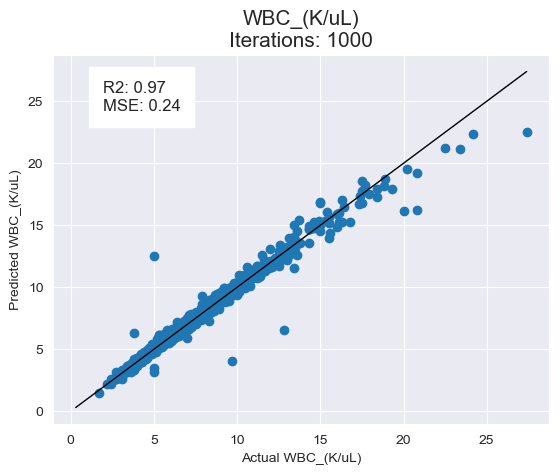

                                           Feature Id  Importances
0                                      ABS_NEUT_(/uL)    43.206223
1                                      ABS_MONO_(/uL)    12.660582
2                                     ABS_LYMPH_(/uL)    12.258767
3                                      ABS_BASO_(/uL)     6.176559
4                                     LYMPHOCYTES_(%)     5.308964
5                                            NEUT_(%)     3.730711
6                                             EOS_(%)     3.550528
7                                            MONO_(%)     2.322997
8                                       ABS_EOS_(/uL)     2.148635
9                                            BASO_(%)     2.089165
10                                          DOSE_(Gy)     1.100443
11                                                AGE     1.074750
12                                 MONTHS_SINCE_IRRAD     0.776039
13                              Hemaglobin_(HGB_g/dL)     0.68

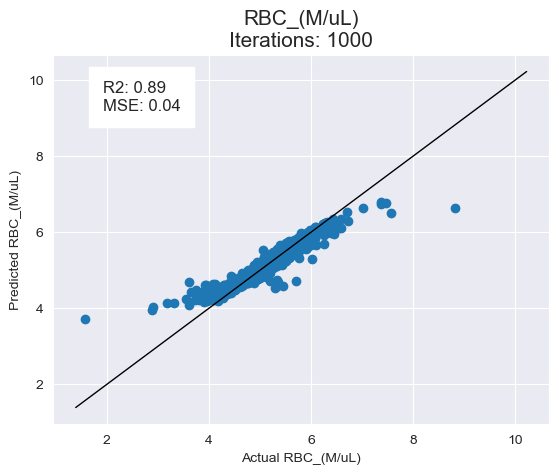

                                           Feature Id  Importances
0                               Hemaglobin_(HGB_g/dL)    32.734695
1                                    Hemocrit_(HCT_%)    31.342808
2                    Mean_corpuscular_volume_(MCV_fL)     9.241793
3                                             Species     7.237171
4                Mean_corpuscular_hemaglobin_(MCH_pg)     7.103853
5                                                 SEX     2.362737
6                                           DOSE_(Gy)     2.039922
7                                     MONTHS AT IRRAD     1.124140
8                                    DAYS_SINCE_IRRAD     0.950769
9                                  MONTHS_SINCE_IRRAD     0.799278
10  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.770389
11                                                AGE     0.726533
12                                              IRRAD     0.633401
13                                    ABS_LYMPH_(/uL)     0.61

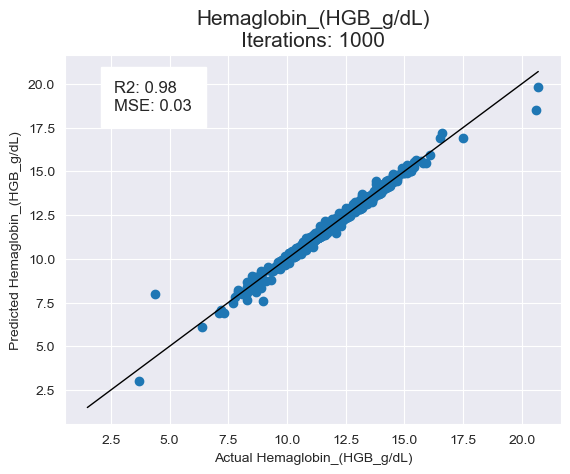

                                           Feature Id  Importances
0                                          RBC_(M/uL)    33.867022
1                                    Hemocrit_(HCT_%)    32.407729
2                Mean_corpuscular_hemaglobin_(MCH_pg)     8.076324
3   Mean_corpuscular_hemaglobin_concentration_(MCH...     6.266644
4                    Mean_corpuscular_volume_(MCV_fL)     4.920312
5                                                 SEX     3.300323
6                                             Species     1.976925
7                                               IRRAD     1.467678
8                                           DOSE_(Gy)     1.392005
9                                    DAYS_SINCE_IRRAD     1.101811
10                               PLATLET_COUNT_(K/uL)     0.913963
11                                    MONTHS AT IRRAD     0.588056
12                                    ABS_LYMPH_(/uL)     0.488376
13                                           MONO_(%)     0.45

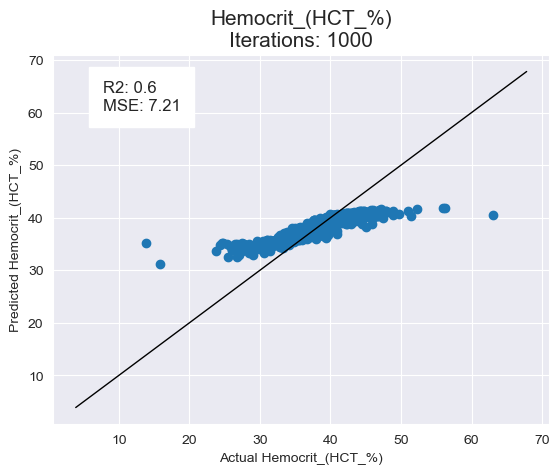

                                           Feature Id  Importances
0                                          RBC_(M/uL)    34.904127
1                               Hemaglobin_(HGB_g/dL)    32.417308
2                    Mean_corpuscular_volume_(MCV_fL)     8.149005
3   Mean_corpuscular_hemaglobin_concentration_(MCH...     4.212238
4                                             Species     2.855804
5                                           DOSE_(Gy)     2.522410
6                Mean_corpuscular_hemaglobin_(MCH_pg)     2.369820
7                                               IRRAD     1.526070
8                                                 AGE     1.447113
9                                                 SEX     1.378021
10                                               TYPE     0.983021
11                               PLATLET_COUNT_(K/uL)     0.963294
12                                      ABS_EOS_(/uL)     0.855795
13                                   DAYS_SINCE_IRRAD     0.69

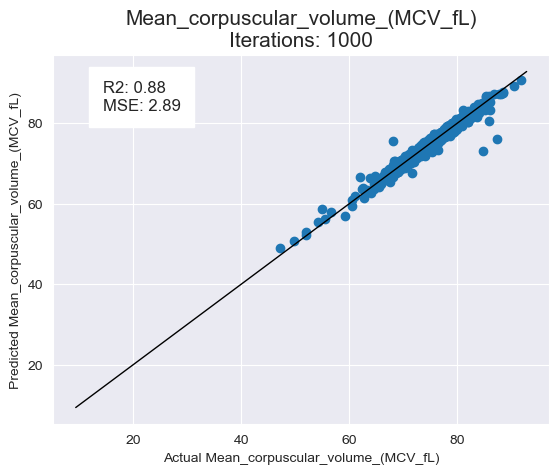

                                           Feature Id  Importances
0                Mean_corpuscular_hemaglobin_(MCH_pg)    36.132997
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    17.874102
2                                          RBC_(M/uL)    10.873411
3                               Hemaglobin_(HGB_g/dL)     9.305488
4                                    Hemocrit_(HCT_%)     6.626952
5                                                TYPE     1.992517
6                                            MONO_(%)     1.859687
7                                PLATLET_COUNT_(K/uL)     1.825057
8                                     MONTHS AT IRRAD     1.320609
9                                      ABS_MONO_(/uL)     1.281503
10                                                AGE     1.192833
11                                          DOSE_(Gy)     1.115489
12                                      ABS_EOS_(/uL)     0.954240
13                                    ABS_LYMPH_(/uL)     0.94

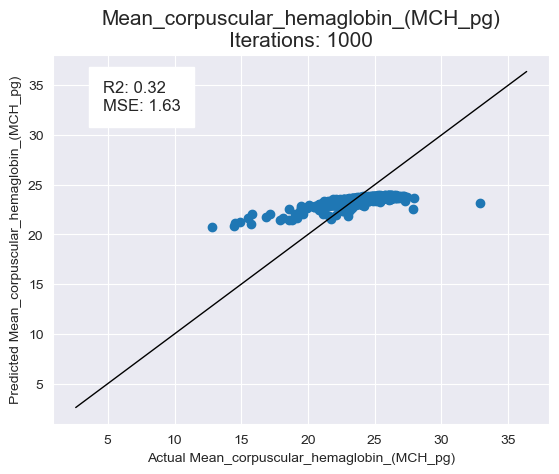

                                           Feature Id  Importances
0                    Mean_corpuscular_volume_(MCV_fL)    34.877205
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    15.214504
2                                          RBC_(M/uL)    12.728290
3                               Hemaglobin_(HGB_g/dL)    11.660381
4                                    Hemocrit_(HCT_%)     7.969993
5                                            NEUT_(%)     1.495611
6                                PLATLET_COUNT_(K/uL)     1.309787
7                                           DOSE_(Gy)     1.273915
8                                            MONO_(%)     1.242029
9                                     ABS_LYMPH_(/uL)     1.240994
10                                                SEX     1.195945
11                                     ABS_MONO_(/uL)     1.191919
12                                    LYMPHOCYTES_(%)     1.125352
13                                                AGE     0.96

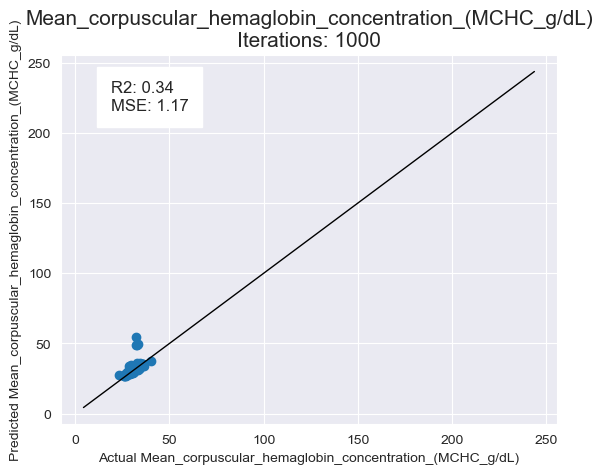

                              Feature Id  Importances
0       Mean_corpuscular_volume_(MCV_fL)    25.655178
1   Mean_corpuscular_hemaglobin_(MCH_pg)    20.561302
2                        MONTHS AT IRRAD    19.155892
3                                Species    10.436710
4                  Hemaglobin_(HGB_g/dL)     5.087195
5                       Hemocrit_(HCT_%)     2.991836
6                                   TYPE     2.427540
7                             RBC_(M/uL)     1.446841
8                         ABS_MONO_(/uL)     1.206206
9                   PLATLET_COUNT_(K/uL)     1.156619
10                              MONO_(%)     1.108621
11                    MONTHS_SINCE_IRRAD     0.905112
12                                   SEX     0.806779
13                              BASO_(%)     0.796983
14                       ABS_LYMPH_(/uL)     0.756028
15                        ABS_NEUT_(/uL)     0.720808
16                               EOS_(%)     0.639318
17                        AB

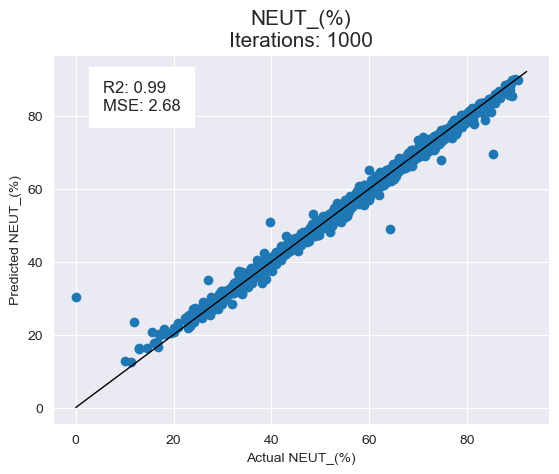

                                           Feature Id  Importances
0                                     LYMPHOCYTES_(%)    56.206517
1                                      ABS_NEUT_(/uL)    18.254733
2                                     ABS_LYMPH_(/uL)    10.967066
3                                          WBC_(K/uL)     2.948111
4                                            MONO_(%)     2.690198
5                                             EOS_(%)     2.320290
6                                       ABS_EOS_(/uL)     1.284941
7                                      ABS_MONO_(/uL)     0.911554
8                                            BASO_(%)     0.646036
9                                PLATLET_COUNT_(K/uL)     0.615668
10                                                AGE     0.533917
11                              Hemaglobin_(HGB_g/dL)     0.368441
12                                               TYPE     0.316293
13                                   DAYS_SINCE_IRRAD     0.26

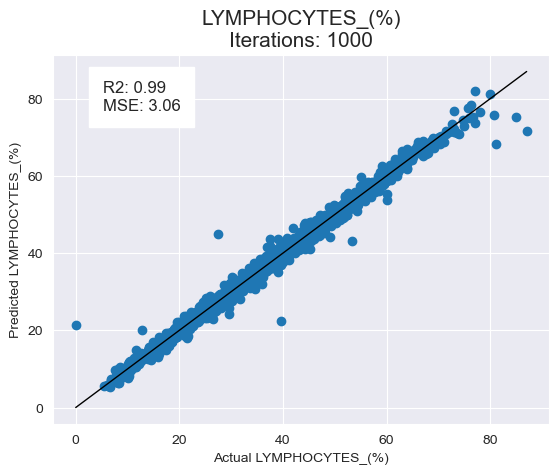

                                           Feature Id  Importances
0                                            NEUT_(%)    35.261770
1                                     ABS_LYMPH_(/uL)    19.419525
2                                      ABS_NEUT_(/uL)    18.136523
3                                          WBC_(K/uL)     7.018026
4                                             EOS_(%)     3.767290
5                                       ABS_EOS_(/uL)     2.666677
6                                            MONO_(%)     1.702732
7                                    DAYS_SINCE_IRRAD     1.448602
8                                      ABS_MONO_(/uL)     1.218450
9                                                 SEX     1.122782
10                                                AGE     1.074541
11                                     ABS_BASO_(/uL)     0.933932
12                                            Species     0.700668
13                                           BASO_(%)     0.69

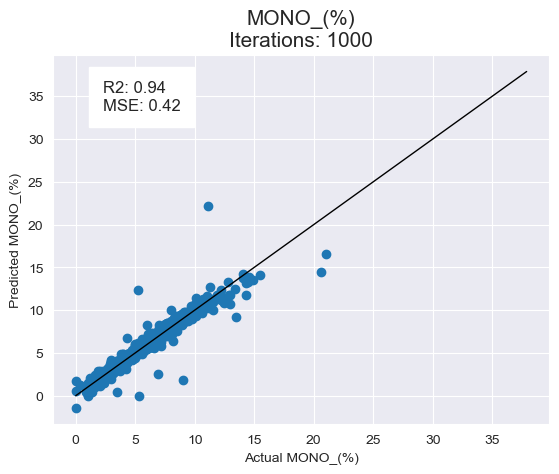

                                           Feature Id  Importances
0                                      ABS_MONO_(/uL)    49.266171
1                                          WBC_(K/uL)    10.665113
2                                      ABS_NEUT_(/uL)     6.221299
3                                            NEUT_(%)     6.120797
4                                     ABS_LYMPH_(/uL)     4.103333
5                                                 AGE     3.927450
6                                  MONTHS_SINCE_IRRAD     3.289139
7                                     LYMPHOCYTES_(%)     2.338041
8                                     MONTHS AT IRRAD     2.250318
9                                             Species     1.670576
10                                   DAYS_SINCE_IRRAD     1.613615
11                                          DOSE_(Gy)     1.398605
12                                         RBC_(M/uL)     0.960743
13                               PLATLET_COUNT_(K/uL)     0.90

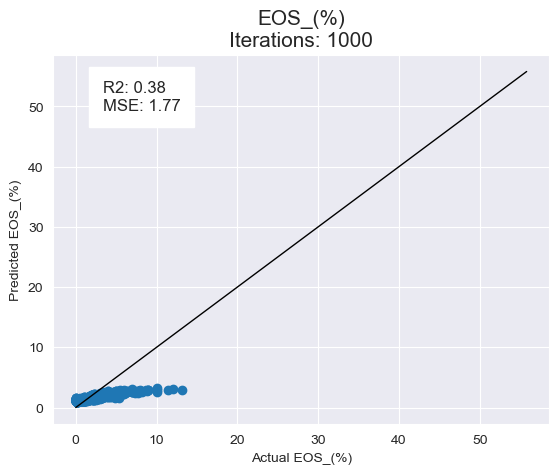

                                           Feature Id  Importances
0                                       ABS_EOS_(/uL)    58.675772
1                                      ABS_NEUT_(/uL)     6.766584
2                                            NEUT_(%)     4.768104
3                                          WBC_(K/uL)     3.809351
4                                    DAYS_SINCE_IRRAD     3.578143
5                                                TYPE     2.594634
6                                     LYMPHOCYTES_(%)     2.198069
7                                             Species     2.171433
8                                     ABS_LYMPH_(/uL)     2.076395
9                                      ABS_BASO_(/uL)     1.976630
10                                 MONTHS_SINCE_IRRAD     1.333905
11                                                AGE     1.128552
12                                     ABS_MONO_(/uL)     1.012770
13               Mean_corpuscular_hemaglobin_(MCH_pg)     0.96

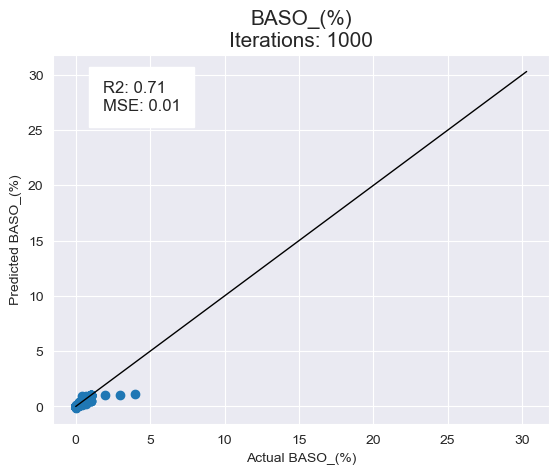

                                           Feature Id  Importances
0                                            NEUT_(%)    38.170429
1                                  MONTHS_SINCE_IRRAD    29.638394
2                    Mean_corpuscular_volume_(MCV_fL)    25.334774
3                                      ABS_BASO_(/uL)     4.393168
4                                          WBC_(K/uL)     0.499004
5                                      ABS_NEUT_(/uL)     0.492144
6                                             Species     0.373603
7                                     ABS_LYMPH_(/uL)     0.212490
8                                      ABS_MONO_(/uL)     0.203144
9                                                 SEX     0.138619
10                               PLATLET_COUNT_(K/uL)     0.075616
11                                   Hemocrit_(HCT_%)     0.074167
12                                    LYMPHOCYTES_(%)     0.069839
13  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.04

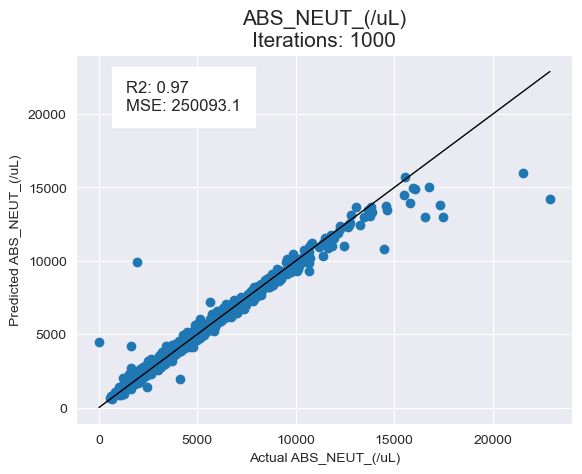

                                           Feature Id  Importances
0                                          WBC_(K/uL)    35.271122
1                                     LYMPHOCYTES_(%)    31.661351
2                                            NEUT_(%)     7.977152
3                                      ABS_BASO_(/uL)     5.812468
4                                     ABS_LYMPH_(/uL)     4.457051
5                                            BASO_(%)     4.311144
6                                      ABS_MONO_(/uL)     2.858193
7                                       ABS_EOS_(/uL)     1.955614
8                                            MONO_(%)     1.754007
9                                             EOS_(%)     1.215385
10                                              IRRAD     0.511315
11                                          DOSE_(Gy)     0.419871
12                                            Species     0.364907
13                                   DAYS_SINCE_IRRAD     0.26

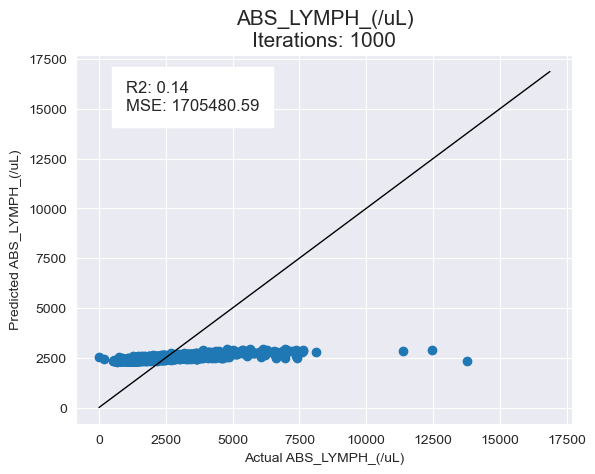

                                           Feature Id  Importances
0                                            NEUT_(%)    29.359155
1                                          WBC_(K/uL)    21.999048
2                                     LYMPHOCYTES_(%)    21.601184
3                                      ABS_NEUT_(/uL)     6.159905
4                                       ABS_EOS_(/uL)     4.077898
5                                      ABS_MONO_(/uL)     2.726148
6                                                 AGE     1.877620
7                                             EOS_(%)     1.428189
8                                            MONO_(%)     1.421654
9                                PLATLET_COUNT_(K/uL)     1.248835
10                                               TYPE     1.188486
11                                     ABS_BASO_(/uL)     1.184262
12                                            Species     0.871119
13                              Hemaglobin_(HGB_g/dL)     0.63

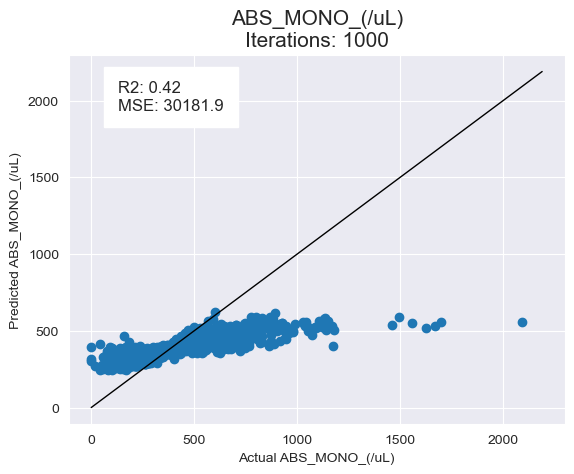

                                           Feature Id  Importances
0                                            MONO_(%)    47.244124
1                                          WBC_(K/uL)    20.424015
2                                     ABS_LYMPH_(/uL)     6.345325
3                                      ABS_NEUT_(/uL)     6.135226
4                                     LYMPHOCYTES_(%)     2.942488
5                                     MONTHS AT IRRAD     2.243671
6                                  MONTHS_SINCE_IRRAD     1.573525
7                                      ABS_BASO_(/uL)     1.363429
8                                           DOSE_(Gy)     1.101693
9                                             Species     1.021773
10                                   DAYS_SINCE_IRRAD     0.911021
11                              Hemaglobin_(HGB_g/dL)     0.909099
12                                           NEUT_(%)     0.878594
13                                      ABS_EOS_(/uL)     0.86

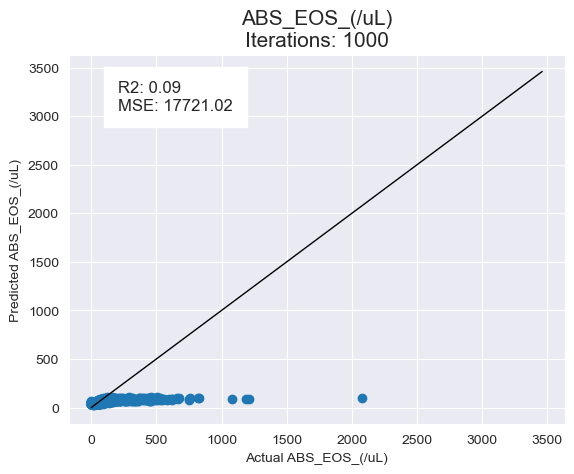

                                           Feature Id  Importances
0                                             EOS_(%)    50.456930
1                                      ABS_NEUT_(/uL)     6.101553
2                                          WBC_(K/uL)     5.747066
3                                            NEUT_(%)     3.674828
4                                     ABS_LYMPH_(/uL)     3.588417
5                                           DOSE_(Gy)     2.537145
6                                          RBC_(M/uL)     2.531625
7                                    DAYS_SINCE_IRRAD     2.302584
8                                  MONTHS_SINCE_IRRAD     2.242648
9                                                 AGE     2.168379
10                                     ABS_MONO_(/uL)     1.962846
11               Mean_corpuscular_hemaglobin_(MCH_pg)     1.940655
12                                    LYMPHOCYTES_(%)     1.866789
13                                     ABS_BASO_(/uL)     1.67

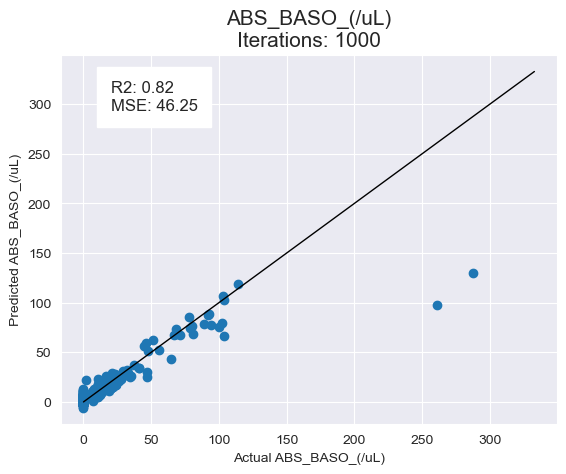

                                           Feature Id  Importances
0                                            BASO_(%)    62.092879
1                                          WBC_(K/uL)     6.048522
2                                      ABS_NEUT_(/uL)     3.270503
3                                     ABS_LYMPH_(/uL)     2.797094
4                                      ABS_MONO_(/uL)     2.699241
5                                            NEUT_(%)     2.459477
6   Mean_corpuscular_hemaglobin_concentration_(MCH...     2.402456
7                                             EOS_(%)     1.864022
8                    Mean_corpuscular_volume_(MCV_fL)     1.657650
9                                PLATLET_COUNT_(K/uL)     1.534797
10                                         RBC_(M/uL)     1.494167
11                                      ABS_EOS_(/uL)     1.452454
12                                           MONO_(%)     1.405285
13                                   DAYS_SINCE_IRRAD     1.30

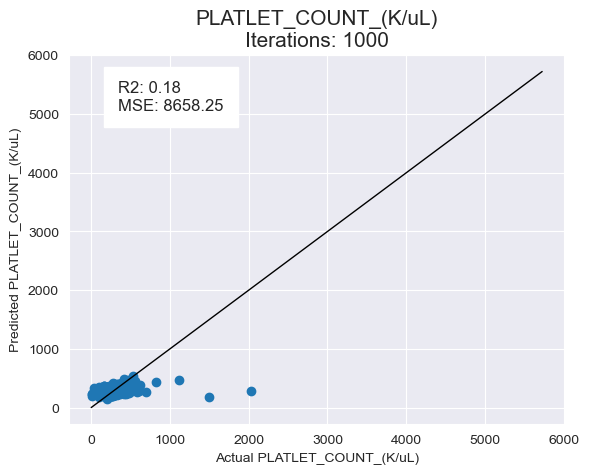

                                           Feature Id  Importances
0                                      ABS_MONO_(/uL)    11.578761
1                                                 AGE     8.940321
2   Mean_corpuscular_hemaglobin_concentration_(MCH...     7.278571
3                                            MONO_(%)     6.726691
4                                     ABS_LYMPH_(/uL)     6.174863
5                Mean_corpuscular_hemaglobin_(MCH_pg)     5.383780
6                                          WBC_(K/uL)     4.616044
7                                           DOSE_(Gy)     4.374330
8                                     MONTHS AT IRRAD     4.349471
9                    Mean_corpuscular_volume_(MCV_fL)     3.798814
10                              Hemaglobin_(HGB_g/dL)     3.473775
11                                   DAYS_SINCE_IRRAD     3.428068
12                                              IRRAD     3.214699
13                                     ABS_NEUT_(/uL)     2.87

In [40]:
optomized_regression_cycler (cyclebio_df)

# Input your own data
Be able to input values for irrad features and have the model make predictions based on just that - trained on multi monkey data

In [31]:
def my_health_api (li):
    vector = []
    vector2 = ['age','dose','days','months','age_at']
    age = float(input('Age (yr)'))
    vector.append(age)
    
    
    dose = float(input('Radiation dose (Gy)'))
    vector.append(dose)
    
    
    days = float(input('Days since exposure'))
    vector.append(days)
    
    
    months = float(input('Months since exposure'))
    vector.append(months)
    
    
    age_at = float(input('Age at exposure (mo)'))
    vector.append(months)
    

    
    df = pd.DataFrame(data=vector, columns=vector2)
    
    #print(a)
    print(df.head())

In [32]:
vector = []
my_health_api (vector)


Age (yr) 5
Radiation dose (Gy) 5
Days since exposure 10
Months since exposure 0
Age at exposure (mo) 5


ValueError: Shape of passed values is (5, 1), indices imply (5, 5)

In [ ]:
vector2 = ['age','dose','days','months','age_at']
print(vector
     )